In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import optim


Bad key "text.kerning_factor" on line 4 in
C:\Users\rithw\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Helper function for viewing an image and predicting it's class

In [2]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

## 1. Importing the dataset

In [3]:
transforms_applied = transforms.Compose([transforms.ToTensor()])

trainset = datasets.FashionMNIST("./data", train = True, transform = transforms_applied, download = True )
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True )

testset = datasets.FashionMNIST("./data", train = False, transform = transforms_applied, download = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

In [4]:
images, labels = next(iter(trainloader))

In [5]:
# Sample Input Image
labels

tensor([4, 6, 0, 6, 8, 5, 5, 3, 6, 8, 8, 8, 5, 9, 8, 7, 8, 2, 4, 6, 3, 4, 8, 4,
        3, 3, 9, 8, 9, 7, 8, 9, 1, 0, 2, 3, 9, 3, 3, 0, 6, 2, 0, 4, 1, 8, 5, 6,
        6, 1, 4, 3, 2, 0, 6, 4, 3, 0, 6, 2, 4, 2, 2, 1])

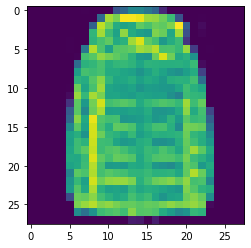

In [6]:
plt.imshow(images[0].view(28,28));

## 2. Defining the architecture of the model

In [7]:
n_input = 784
n_hidden = [256,128,64]
n_output = 10

In [8]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(n_input, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.output = nn.Linear(n_hidden[2], n_output)
        
        # Adding Dropout to prveent Overfitting
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # Output layer hence we won't be adding dropout
        x = F.log_softmax(self.output(x), dim = 1)
        
        return x

In [9]:
model = Network()

## 3. Defining the Criterion and Optimizer 

In [10]:
criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)

## 4. Training the Neural Network

In [11]:
epochs = 30 


train_loss_array = []
test_loss_array = []

for iterations in range(epochs):    
    
    running_loss = 0

    for images, labels in iter(trainloader):
        
        optimizer.zero_grad()
        
        images = images.view(images.shape[0], -1)
        
        predictions = model(images)
        
        loss = criterion(predictions, labels)
        
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            
            model.eval()
            
            for images_test, labels_test in iter(testloader):

                images_test = images_test.view(images_test.shape[0], -1)
                log_predictions = model.forward(images_test)
                

                test_loss += criterion(log_predictions, labels_test)

                predictions = torch.exp(log_predictions)

                top_p, top_class = predictions.topk(1, dim = 1)
                equals = top_class == labels_test.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        
        model.train()
        train_loss_array.append(running_loss/len(trainloader))
        test_loss_array.append(test_loss/len(testloader))

        print("Epoch : {}/{}..." .format(iterations+1, epochs),
             "Training Loss : {:.3f}.." .format(running_loss/len(trainloader)),
             "Test Loss : {:.3f}.." .format(test_loss/len(testloader)),
             "Test Accuracy: {:.3f}" .format(accuracy/len(testloader)))
        


Epoch : 1/30... Training Loss : 1.929.. Test Loss : 1.214.. Test Accuracy: 0.553
Epoch : 2/30... Training Loss : 1.063.. Test Loss : 0.830.. Test Accuracy: 0.674
Epoch : 3/30... Training Loss : 0.836.. Test Loss : 0.707.. Test Accuracy: 0.739
Epoch : 4/30... Training Loss : 0.735.. Test Loss : 0.644.. Test Accuracy: 0.767
Epoch : 5/30... Training Loss : 0.671.. Test Loss : 0.589.. Test Accuracy: 0.792
Epoch : 6/30... Training Loss : 0.621.. Test Loss : 0.552.. Test Accuracy: 0.806
Epoch : 7/30... Training Loss : 0.584.. Test Loss : 0.521.. Test Accuracy: 0.817
Epoch : 8/30... Training Loss : 0.554.. Test Loss : 0.508.. Test Accuracy: 0.821
Epoch : 9/30... Training Loss : 0.528.. Test Loss : 0.485.. Test Accuracy: 0.827
Epoch : 10/30... Training Loss : 0.507.. Test Loss : 0.466.. Test Accuracy: 0.834
Epoch : 11/30... Training Loss : 0.489.. Test Loss : 0.467.. Test Accuracy: 0.831
Epoch : 12/30... Training Loss : 0.474.. Test Loss : 0.446.. Test Accuracy: 0.841
Epoch : 13/30... Training

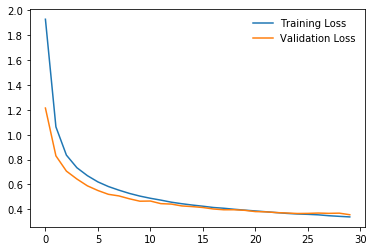

In [12]:
plt.plot(train_loss_array, label = "Training Loss")
plt.plot(test_loss_array, label = "Validation Loss")
plt.legend(frameon = False)